Trying to code up a CNN based on resnet50 from scratch.

In [1]:
from importlib import reload
import flymovie as fm

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


In [2]:
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-202112')
target_shape = (200, 200)
channels_axis=1

In [39]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments}
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of 3 integers, the number of filters for each of the 3 convolution layers
                **note: The last filter must equal be same as input (for adding in resnet shortcut)
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=channels_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=channels_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=channels_axis, name=bn_name_base + '2c')(x)
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


In [40]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.

    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.

    # Returns
        Output tensor for the block.

    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=channels_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=channels_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=channels_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=channels_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [41]:
img_input = layers.Input(shape=(1,) + target_shape)
x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
x = layers.Conv2D(64, (7,7),
                    strides=(2, 2),
                    padding='valid',
                    kernel_initializer='he_normal',
                    name='conv1')(x)
x = layers.BatchNormalization( name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)


x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
"""
x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
"""
x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_cnn = Model(img_input, x, name='resnet_stad1')

In [70]:
def make_triplet_inputs(folder):
    def preprocess_image_fromfile(filename):
        image = fm.load_pickle(filename)
        return preprocess_image(image)
    
    def preprocess_image(image):
        """
        Load the specified pkl file, make max intensity projection, normalize.
        """
        mip = image.max(axis=0)
        mip = mip.astype('float32')
        mip = np.expand_dims(mip, axis=0)
        #mip = np.vstack([mip, mip, mip])
        #mip = np.swapaxes(mip, 0, 2)
        # Normalize 0-1.
        mip = (mip - np.min(mip)) / np.max(mip) 
        return mip

    ## Make lists of anchor, positive, and negative datasets.

    # Set directories.
    cache_dir = Path(folder)
    anchor_images_path = cache_dir / "left"
    positive_images_path = cache_dir / "right"

    # Create lists of sorted files for anchor and positive images.
    anchor_image_files = sorted(
        [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
    )

    positive_image_files = sorted(
        [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
    )

    image_count = len(anchor_image_files)

    # To generate the list of negative images, randomize the list of
    # available images and concatenate them together.
    negative_image_files = anchor_image_files + positive_image_files
    np.random.RandomState(seed=32).shuffle(negative_image_files)
    np.random.RandomState(seed=16).shuffle(negative_image_files)
    np.random.RandomState(seed=8).shuffle(negative_image_files)

    # Apply preprocessing to all input images, return as lists.
    anchor_images = list(map(preprocess_image_fromfile, anchor_image_files))
    positive_images = list(map(preprocess_image_fromfile, positive_image_files))
    negative_images = list(map(preprocess_image_fromfile, negative_image_files))

    # Convert lists to tf datasets, shuffle the negatives again for good measure.
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
    negative_dataset = negative_dataset.shuffle(buffer_size=4096)

    # Zip three datasets together to make final dataset, where each entry is a triplet of anchor, positive, and negative images.
    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

    # Split dataset into training and validation sets.
    train_dataset = dataset.take(round(image_count * 0.8))
    val_dataset = dataset.skip(round(image_count * 0.8))

    # Divide training and validation datasets into batches of size 32, prefetch them 
    # (which I still don't totally understand but seems to pre-activate them in some
    # meaningrul way).
    train_dataset = train_dataset.batch(32, drop_remainder=False)
    train_dataset = train_dataset.prefetch(8)

    val_dataset = val_dataset.batch(32, drop_remainder=False)
    val_dataset = val_dataset.prefetch(8)
    return train_dataset, val_dataset

t, v = make_triplet_inputs('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-202112')

In [42]:
def preprocess_image_fromfile(filename):
    image = fm.load_pickle(filename)
    return preprocess_image(image)
    
def preprocess_image(image):
    """
    Load the specified pkl file, make max intensity projection, normalize.
    """
    mip = image.max(axis=0)
    mip = mip.astype('float32')
    mip = np.expand_dims(mip, axis=0)
    #mip = np.vstack([mip, mip, mip])
    #mip = np.swapaxes(mip, 0, 2)
    # Normalize 0-1.
    mip = (mip - np.min(mip)) / np.max(mip) 
    return mip

In [43]:
## Make lists of anchor, positive, and negative datasets.

# Set directories.
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

# Create lists of sorted files for anchor and positive images.
anchor_image_files = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_image_files = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_image_files)

# To generate the list of negative images, randomize the list of
# available images and concatenate them together.
negative_image_files = anchor_image_files + positive_image_files
np.random.RandomState(seed=32).shuffle(negative_image_files)
np.random.RandomState(seed=16).shuffle(negative_image_files)
np.random.RandomState(seed=8).shuffle(negative_image_files)

# Apply preprocessing to all input images, return as lists.
anchor_images = list(map(preprocess_image_fromfile, anchor_image_files))
positive_images = list(map(preprocess_image_fromfile, positive_image_files))
negative_images = list(map(preprocess_image_fromfile, negative_image_files))

# Convert lists to tf datasets, shuffle the negatives again for good measure.
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

# Zip three datasets together to make final dataset, where each entry is a triplet of anchor, positive, and negative images.
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

# Split dataset into training and validation sets.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

# Divide training and validation datasets into batches of size 32, prefetch them 
# (which I still don't totally understand but seems to pre-activate them in some
# meaningrul way).
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

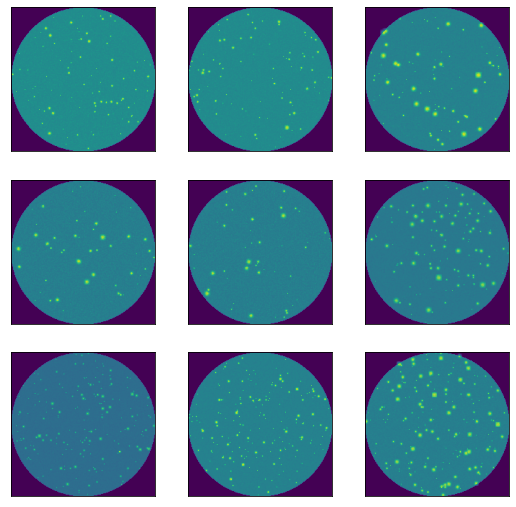

In [71]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i][0])
        show(axs[i, 1], positive[i][0])
        show(axs[i, 2], negative[i][0])

visualize(*list(t.take(1).as_numpy_iterator())[0])

In [44]:
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)
#output = layers.Lambda(lambda x: tf.linalg.l2_normalize(x))(output)

embedding = Model(base_cnn.input, output, name="Embedding")

In [45]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [46]:
anchor_input = layers.Input(name="anchor", shape=(1,) + target_shape)
positive_input = layers.Input(name="positive", shape=(1,) + target_shape)
negative_input = layers.Input(name="negative", shape=(1,) + target_shape)

In [47]:
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [48]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)
    
    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [49]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [ ]:
history = siamese_model.fit(train_dataset, epochs=2, validation_data=val_dataset, verbose=True)

How do we test this?

Need a function that takes images and params, measures 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
sample = next(iter(train_dataset))
#visualize(*sample)

anchor, positive, negative = sample
anchor = anchor.numpy()
positive = positive.numpy()
negative = negative.numpy()
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(preprocess_image(anchor)),
    embedding(preprocess_image(positive)),
    embedding(preprocess_image(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


I think the thing to do is code this up for use on the big machine.

Scripts:

1. Define network, from base cnn on
2. Load network, preprocess data, fit model, eval.
3. Generate sims, auto shift to left and right buckets.

Two things to potentially add:

1. Learning rate scheduler (prob a good idea)
2. Try out curriculum?

In [50]:
reload(fm.cnn_models.siamese_cnn)
base_cnn2 = fm.cnn_models.siamese_cnn.make_base_cnn(image_shape=(200,200))
embedding2 = fm.cnn_models.siamese_cnn.make_embedding(base_cnn2)
siamese_network2 = fm.cnn_models.siamese_cnn.make_siamese_network(embedding2)

#siamese_model2 = SiameseModel(siamese_network2)

(1, 200, 200)


In [58]:
siamese_model2 = SiameseModel(siamese_network2)
siamese_model2.compile(optimizer=optimizers.Adam(0.0001))
history2 = siamese_model2.fit(train_dataset, epochs=2, validation_data=val_dataset, verbose=True)

Epoch 1/2
75/75 [==============================] - 116s 1s/step - loss: 0.4209 - val_loss: 0.2785
Epoch 2/2
75/75 [==============================] - 105s 1s/step - loss: 0.3130 - val_loss: 0.2510


In [53]:
siamese_network2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 1, 200, 200) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 1, 200, 200) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 1, 200, 200) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 256)          29532996    anchor[0][0]                     
                                                                 positive[0][0]             

In [54]:
siamese_network.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 1, 200, 200) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 1, 200, 200) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 1, 200, 200) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 256)          29532996    anchor[0][0]                     
                                                                 positive[0][0]             

In [60]:
import subprocess

In [66]:
subprocess.run('mv /Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-test_jIPnUi6fyr/*_1.pkl /Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-test_jIPnUi6fyr/right', shell=True)

CompletedProcess(args='mv /Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-test_jIPnUi6fyr/*_1.pkl /Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-test_jIPnUi6fyr/right', returncode=0)